# Predict a US presidential election using Bayesian optimal polling

In this tutorial, we explore the use of optimal experimental design techniques to create an optimal polling strategy to predict the outcome of the US presidential election. We take the 2012 election as our prior and the 2016 election as our test set: we imagine that we are conducting polling just before the 2016 election.

## The model
For each of the 50 states we define 

$$ \text{logit }\mathbb{P}(\text{a random voter in state } i \text{ votes Democrat in the 2016 election}) = \theta_i $$

and we assume all other voters vote Republican. Right before the election, the value of $\theta$ is unknown and we wish to estimate it using polling. The winner $w$ of the election is decided by the Electoral College system. The number of electoral college votes gained by the Democrats in state $i$ is
$$
e_i =  \begin{cases}
k_i \text{ if } \theta_i > \frac{1}{2} \\
0 \text{ otherwise}
\end{cases}
$$
(this is a rough approximation of the true system). All other electoral college votes go to the Republicans. Here $k_i$ is the number of electoral college votes alloted to state $i$, which are listed in the following data frame.

In [1]:
import pandas as pd
import torch

electoral_college_votes = pd.read_pickle("electoral_college_votes.pickle")
print(electoral_college_votes)
ec_votes_tensor = torch.tensor(electoral_college_votes.values, dtype=torch.float).squeeze()

       Electoral college votes
State                         
AL                           9
AK                           3
AZ                          11
AR                           6
CA                          55
CO                           9
CT                           7
DE                           3
DC                           3
FL                          29
GA                          16
HI                           4
ID                           4
IL                          20
IN                          11
IA                           6
KS                           6
KY                           8
LA                           8
ME                           4
MD                          10
MA                          11
MI                          16
MN                          10
MS                           6
MO                          10
MT                           3
NE                           5
NV                           6
NH                           4
NJ      

The winner $w$ of the election is

$$ w = \begin{cases}
\text{Democrats if } \sum_i e_i > \frac{1}{2}\sum_i k_i  \\
\text{Republicans otherwise}
\end{cases}
$$

We are interested in polling strategies that will help us predict $w$, rather than predicting the more complex state-by-state results $\theta$.

To set up a fully Bayesian model, we need a prior for $\theta$. We will base the prior on the outcome of some historical presidential elections. Specifically, we'll use the following dataset of state-by-state election results for the presidential elections 1976-2012 inclusive. Note that votes for parties other than Democrats and Republicans have been ignored.

In [2]:
frame = pd.read_pickle("us_presidential_election_data_historical.pickle")
print(frame)

          1976                1980                1984                1988  \
      Democrat Republican Democrat Republican Democrat Republican Democrat   
State                                                                        
AL      659170     504070   636730     654192   551899     872849   815576   
AK       44058      71555    41842      86112    62007     138377   119251   
AZ      295602     418642   246843     529688   333854     681416   702541   
AR      499614     268753   398041     403164   338646     534774   466578   
CA     3742284    3882244  3083661    4524858  3922519    5467009  5054917   
CO      460353     584367   367973     652264   454974     821818   728177   
CT      647895     719261   541732     677210   569597     890877   750241   
DE      122596     109831   105754     111252   101656     152190   139639   
DC      137818      27873   130231      23313   180408      29009    27590   
FL     1636000    1469531  1419475    2046951  1448816    273035

Based on this data alone, we will base our prior mean for $\theta$ solely on the 2012 election. Specifically, we'll choose a prior mean as follows:

In [3]:
results_2012 = torch.tensor(frame[2012].values, dtype=torch.float)
prior_mean = torch.log(results_2012[..., 0] / results_2012[..., 1])
print(prior_mean)

tensor([-0.4564, -0.2947, -0.1851, -0.4961,  0.4842,  0.1100,  0.3546,  0.3825,
         2.5250,  0.0177, -0.1586,  0.9298, -0.6821,  0.3465, -0.2088,  0.1185,
        -0.4521, -0.4702, -0.3535,  0.3170,  0.5460,  0.4805,  0.1926,  0.1580,
        -0.2331, -0.1917, -0.2832, -0.4528,  0.1365,  0.1135,  0.3634,  0.2126,
         0.5884, -0.0414, -0.4104,  0.0606, -0.6979,  0.2522,  0.1094,  0.5761,
        -0.2131, -0.3730, -0.4201, -0.3231, -1.0788,  0.7652,  0.0787,  0.3075,
        -0.5613,  0.1409, -0.9032])


Our prior distribution for $\theta$ will be a multivariate Normal with mean `prior_mean`. The only thing left to decide upon is the covariance matrix.

*Aside*: The prior covariance is important in a number of ways. If we allow too much variance, the prior will be uncertain about the outcome in every state, and require polling everywhere. If we allow too little variance, we may be caught off-guard by an unexpected electoral outcome. If we assume states are independent, then we will not be able to pool information across states; but assume too much correlation and we could too faithfully base predictions about one state from poll results in another.

We select the prior covariance by taking the empirical covariance from the elections 1976 - 2012 and adding a small value `0.01` to the diagonal.

In [4]:
idx = 2 * torch.arange(10)
as_tensor = torch.tensor(frame.values, dtype=torch.float)
logits = torch.log(as_tensor[..., idx] / as_tensor[..., idx + 1]).transpose(0, 1)
mean = logits.mean(0)
sample_covariance = (1/(logits.shape[0] - 1)) * (
    (logits.unsqueeze(-1) - mean) * (logits.unsqueeze(-2) - mean)
).sum(0)
prior_covariance = sample_covariance + 0.01 * torch.eye(sample_covariance.shape[0])
prior_scale_tril = prior_covariance.cholesky()

We are now in a position to define our Bayesian model.

In [5]:
from contextlib import ExitStack

import pyro
import pyro.distributions as dist
from pyro.contrib.util import iter_plates_to_shape

def model(polling_allocation):
    with ExitStack() as stack:
        for plate in iter_plates_to_shape(polling_allocation.shape[:-1]):
            stack.enter_context(plate)
        theta = pyro.sample("theta", dist.MultivariateNormal(prior_mean, scale_tril=prior_scale_tril))
        poll_results = pyro.sample("y", dist.Binomial(polling_allocation, logits=theta).to_event(1))
        dem_win_state = (theta > 0.).float()
        dem_electoral_college_votes = ec_votes_tensor * dem_win_state
        dem_win = dem_electoral_college_votes.sum(-1) / ec_votes_tensor.sum(-1) > .5
        pyro.sample("w", dist.Delta(dem_win))
        return poll_results, dem_win, theta

This Bayesian model implicitly defines our prior on `w`. We can investigate this prior by simulating many times from our prior.

In [6]:
_, dem_wins, theta = model(torch.ones(100000, 51))
print("Prior probability of Dem win", dem_wins.float().mean().item())

Prior probability of Dem win 0.6632699966430664


We can also investigate which states, a priori, are most marginal.

In [7]:
dem_prob = (theta > 0.).float().mean(0)
marginal = torch.argsort((dem_prob - .5).abs()).numpy()
prior_prob_dem = pd.DataFrame({"State": frame.index[marginal],
                               "Democrat win probability": dem_prob.numpy()[marginal]}).set_index('State')
print(prior_prob_dem)

       Democrat win probability
State                          
FL                      0.52522
NC                      0.43683
NH                      0.60733
VA                      0.61833
OH                      0.61965
NV                      0.63383
CO                      0.65049
GA                      0.33434
AZ                      0.31515
IA                      0.72432
PA                      0.72606
AK                      0.26909
SC                      0.26636
MS                      0.22903
IN                      0.22865
MN                      0.77255
WI                      0.77484
MI                      0.77589
NM                      0.79073
MO                      0.19223
NE                      0.16571
MT                      0.16114
ME                      0.84038
CT                      0.84729
TX                      0.14983
ND                      0.14646
OR                      0.85830
IL                      0.86067
MA                      0.86847
WA      

This is a sanity check, and seems to accord with our intuitions. Since our prior is based on 2012 and the Democrats won in 2012, it makes sense that we would favour a Democrat win in 2016 (this is before we have seen *any* polling data or incorporated any other information). Florida is frequently an important swing state and is top of our list of marginal states under the prior. We can also see states such as Pennsylvania and Wisconsin near the top of the list -- we know that these were instrumental in the 2016 election. (This kind of posthoc analysis is, of course, very bad and only engaged in by immoral persons.)

### Regional correlations

Finally, we take a closer look at our prior covariance. Specifically, we examine states that we expect to be more or less correlated.

In [8]:
import numpy as np


def correlation(cov):
    return cov / np.sqrt(np.expand_dims(np.diag(cov.values), 0) * np.expand_dims(np.diag(cov.values), 1))
                

new_england_states = ['ME', 'VT', 'NH', 'MA', 'RI', 'CT']
cov_as_frame = pd.DataFrame(prior_covariance.numpy(), columns=frame.index).set_index(frame.index)
ne_cov = cov_as_frame.loc[new_england_states, new_england_states]
ne_corr = correlation(ne_cov)
print(ne_corr)

State        ME        VT        NH        MA        RI        CT
State                                                            
ME     1.000000  0.819736  0.708824  0.691700  0.670969  0.843993
VT     0.819736  1.000000  0.519503  0.797010  0.799352  0.855304
NH     0.708824  0.519503  1.000000  0.301555  0.195725  0.662055
MA     0.691700  0.797010  0.301555  1.000000  0.918948  0.788008
RI     0.670969  0.799352  0.195725  0.918948  1.000000  0.761820
CT     0.843993  0.855304  0.662055  0.788008  0.761820  1.000000


In [9]:
southern_states = ['LA', 'MS', 'AL', 'GA', 'SC']
southern_cov = cov_as_frame.loc[southern_states, southern_states]
southern_corr = correlation(southern_cov)
print(southern_corr)

State        LA        MS        AL        GA        SC
State                                                  
LA     1.000000  0.702031  0.756532  0.558173  0.669294
MS     0.702031  1.000000  0.856342  0.707460  0.871555
AL     0.756532  0.856342  1.000000  0.761144  0.844517
GA     0.558173  0.707460  0.761144  1.000000  0.809025
SC     0.669294  0.871555  0.844517  0.809025  1.000000


These correlation matrices show that, as expected, logical groupings of states tend to have similar voting trends.

In [10]:
cross_cov = cov_as_frame.loc[new_england_states + southern_states, new_england_states + southern_states]
cross_corr = correlation(cross_cov)
print(cross_corr.loc[new_england_states, southern_states])

State        LA        MS        AL        GA        SC
State                                                  
ME     0.143958  0.018036 -0.172994  0.032646  0.093751
VT    -0.266697 -0.352180 -0.560951 -0.294640 -0.279492
NH     0.381440  0.358118  0.180448  0.117459  0.397982
MA    -0.216447 -0.520811 -0.572776 -0.263084 -0.400615
RI    -0.266150 -0.531253 -0.602058 -0.265214 -0.433672
CT    -0.044753 -0.193657 -0.360299 -0.178306 -0.111733


Finally, to check the data that led to these values, here is a scatter plot comparing Alabama with 1) South Carolina, 2) Connecticut

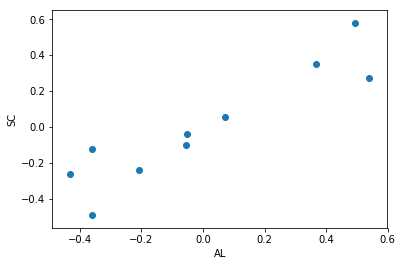

In [14]:
import matplotlib.pyplot as plt

data = (logits - mean)[...,[0,6,40]].numpy()
x, y = data[..., 0], data[..., 2]
plt.scatter(x, y)
plt.xlabel("AL")
plt.ylabel("SC")
plt.show()

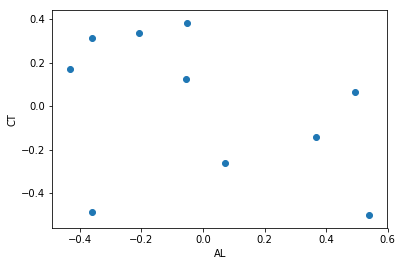

In [12]:
x, y = data[..., 0], data[..., 1]
plt.scatter(x, y)
plt.xlabel("AL")
plt.ylabel("CT")
plt.show()

## Measuring the expected information gain of a polling strategy
The prior we have set up appears to accord, at least approximately, with intuition. However, we now want to add a second source of information from polling. We aim to use our prior to select a polling strategy that will be most informative about our target $w$. A polling strategy, in this simplified set-up, is the number of people to poll in each state. (We ignore any other covariates such as regional variation inside states, demographics, etc.) We might imagine that polling 1000 people in Florida (the most marginal state), will be much more effective than polling 1000 people in Hawaii (the least marginal state). That's because the outcome in Hawaii is already quite predictable, just based on our prior, whereas the outcome in Florida is really up for grabs.

In fact, the information that our model will gain about $w$ based on conducting a poll with design $d$ and getting outcome $y$ can be described mathematically as follows:

$$\text(IG)(d, y) = KL(p(w|y,d)||p(w))$$

Since the outcome of the poll is at present unknown, we consider the expected information gain

$$\text{EIG}(d) = \mathbb{E}_{p(y|d)}\quad[KL(p(w|y,d)||p(w))]$$.

To estimate the EIG, we make use of the following variational representation

$$\text{EIG}(d) = \max_q \mathbb{E}_{p(w, y|d)}\quad\left[\log q(w|y,d) \right] + H(p(w))$$

What is $q$? It is a machine that takes as input $y$ and outputs a distribution over $w$. Since $w$ is a binary random variable, we can think of $q$ as a classifier that tries to decide, based on the poll outcome, who the eventual winner of the election will be. In this notebook, $q$ will be a neural classifier.

In [13]:
from torch import nn

class OutcomePredictor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(51, 256)
        self.lin2 = nn.Linear(256, 256)
        self.lin3 = nn.Linear(256, 1)
        
    def compute_dem_probability(self, y):
        y = F.relu(self.lin1(y))
        y = F.relu(self.lin2(y))
        return self.lin3(y)
    
    def forward(self, )

SyntaxError: invalid syntax (<ipython-input-13-4fd0aa0c0002>, line 16)